In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date, timedelta
import torch
import torch.nn as nn

In [2]:
data = pd.read_csv('lahore.csv')

In [3]:
data

,date,AQI,latitude,longitude
0,2023-09-22 00:00:00,103.220,31.742221,74.474629
1,2023-09-22 01:00:00,105.735,31.742221,74.474629
2,2023-09-22 02:00:00,109.670,31.742221,74.474629
3,2023-09-22 03:00:00,108.705,31.742221,74.474629
4,2023-09-22 04:00:00,101.325,31.742221,74.474629
...,...,...,...,...
4501,2024-04-19 20:00:00,78.665,31.742221,74.474629
4502,2024-04-19 21:00:00,69.900,31.742221,74.474629
4503,2024-04-19 22:00:00,65.780,31.742221,74.474629
4504,2024-04-19 23:00:00,73.635,31.742221,74.474629


In [4]:
data = data[['date', 'AQI']]
data

,date,AQI
0,2023-09-22 00:00:00,103.220
1,2023-09-22 01:00:00,105.735
2,2023-09-22 02:00:00,109.670
3,2023-09-22 03:00:00,108.705
4,2023-09-22 04:00:00,101.325
...,...,...
4501,2024-04-19 20:00:00,78.665
4502,2024-04-19 21:00:00,69.900
4503,2024-04-19 22:00:00,65.780
4504,2024-04-19 23:00:00,73.635


In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

C:\Users\timmy\AppData\Local\Temp\ipykernel_17836\3395756933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])


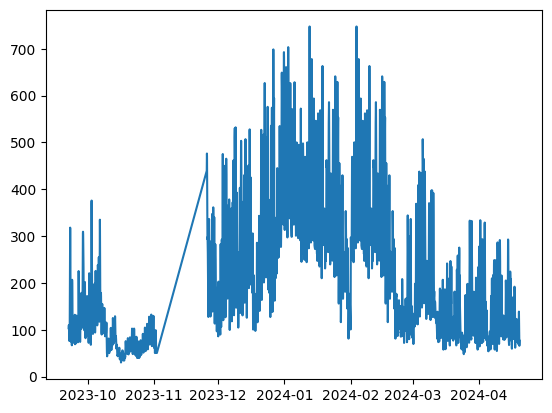

In [6]:
data['date'] = pd.to_datetime(data['date'])

plt.plot(data['date'], data['AQI'])

In [7]:
from copy import deepcopy as dc

def prepare_data(df, n_steps):
  df = dc(df)
  df['date'] = pd.to_datetime(df['date'])

  df.set_index('date', inplace=True)

  for i in range(1, n_steps+1):
    df[f"AQI(t-{i})"] = df['AQI'].shift(i)

  df.dropna(inplace=True)

  return df

lookback = 6
shifted_df = prepare_data(data, lookback)
shifted_df

,AQI,AQI(t-1),AQI(t-2),AQI(t-3),AQI(t-4),AQI(t-5),AQI(t-6)
date,,,,,,,
2023-09-22 06:00:00,82.490,91.290,101.325,108.705,109.670,105.735,103.220
2023-09-22 07:00:00,77.780,82.490,91.290,101.325,108.705,109.670,105.735
2023-09-22 08:00:00,76.005,77.780,82.490,91.290,101.325,108.705,109.670
2023-09-22 09:00:00,76.350,76.005,77.780,82.490,91.290,101.325,108.705
2023-09-22 10:00:00,76.945,76.350,76.005,77.780,82.490,91.290,101.325
...,...,...,...,...,...,...,...
2024-04-19 20:00:00,78.665,98.135,123.350,138.695,133.635,111.310,92.715
2024-04-19 21:00:00,69.900,78.665,98.135,123.350,138.695,133.635,111.310
2024-04-19 22:00:00,65.780,69.900,78.665,98.135,123.350,138.695,133.635


In [8]:
# converting to an array
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 82.49 ,  91.29 , 101.325, ..., 109.67 , 105.735, 103.22 ],
       [ 77.78 ,  82.49 ,  91.29 , ..., 108.705, 109.67 , 105.735],
       [ 76.005,  77.78 ,  82.49 , ..., 101.325, 108.705, 109.67 ],
       ...,
       [ 65.78 ,  69.9  ,  78.665, ..., 123.35 , 138.695, 133.635],
       [ 73.635,  65.78 ,  69.9  , ...,  98.135, 123.35 , 138.695],
       [ 76.665,  73.635,  65.78 , ...,  78.665,  98.135, 123.35 ]])

In [9]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((4500, 6), (4500,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[103.22 , 105.735, 109.67 , 108.705, 101.325,  91.29 ],
       [105.735, 109.67 , 108.705, 101.325,  91.29 ,  82.49 ],
       [109.67 , 108.705, 101.325,  91.29 ,  82.49 ,  77.78 ],
       ...,
       [133.635, 138.695, 123.35 ,  98.135,  78.665,  69.9  ],
       [138.695, 123.35 ,  98.135,  78.665,  69.9  ,  65.78 ],
       [123.35 ,  98.135,  78.665,  69.9  ,  65.78 ,  73.635]])

In [11]:
# scaling the data
from sklearn.preprocessing import StandardScaler

data_scaler = StandardScaler()
target_scaler = StandardScaler()
X = data_scaler.fit_transform(X)
y = target_scaler.fit_transform(y.reshape(-1, 1))


In [12]:
y

array([[-0.97649846],
       [-1.00863975],
       [-1.02075245],
       ...,
       [-1.09052839],
       [-1.03692545],
       [-1.01624857]])

In [13]:
# saving the scaler
import joblib

joblib.dump(data_scaler, 'data_scaler.pkl')
joblib.dump(target_scaler, 'target_scaler.pkl')

['target_scaler.pkl']

In [14]:
# loading the scaler
data_scaler = joblib.load('data_scaler.pkl')
target_scaler = joblib.load('target_scaler.pkl')

In [15]:
split_index = int(len(X) * 0.98)

split_index

4410

In [16]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4410, 6), (90, 6), (4410, 1), (90, 1))

In [17]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4410, 6, 1), (90, 6, 1), (4410, 1), (90, 1))

In [18]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4410, 6, 1]),
 torch.Size([90, 6, 1]),
 torch.Size([4410, 1]),
 torch.Size([90, 1]))

In [19]:
# Creating a dataset
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [20]:
train_dataset

In [21]:
# Data Loader
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 6, 1]) torch.Size([16, 1])


In [23]:
# LSTM Model


class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_stacked_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_layers = num_stacked_layers

    self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    batch_size = x.size(0)
    h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out



In [24]:
model = LSTM(1, 12, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 12, batch_first=True)
  (fc): Linear(in_features=12, out_features=1, bias=True)
)

In [25]:
def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch +1 }')

  running_loss = 0.0

  for batch_index, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 100==99: # printing every 100 batch
      avg_loss_across_batches = running_loss/100
      print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                  avg_loss_across_batches))
      running_loss = 0.0
  print()

In [28]:
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(test_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

  avg_loss_across_batches = running_loss / len(test_loader)

  print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
  print('***************************************************')
  print()

In [29]:
learning_rate = 0.0001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.105
Batch 200, Loss: 0.102

Val Loss: 0.018
***************************************************

Epoch: 2
Batch 100, Loss: 0.096
Batch 200, Loss: 0.096

Val Loss: 0.019
***************************************************

Epoch: 3
Batch 100, Loss: 0.087
Batch 200, Loss: 0.080

Val Loss: 0.018
***************************************************

Epoch: 4
Batch 100, Loss: 0.074
Batch 200, Loss: 0.075

Val Loss: 0.016
***************************************************

Epoch: 5
Batch 100, Loss: 0.070
Batch 200, Loss: 0.063

Val Loss: 0.017
***************************************************

Epoch: 6
Batch 100, Loss: 0.065
Batch 200, Loss: 0.064

Val Loss: 0.014
***************************************************

Epoch: 7
Batch 100, Loss: 0.059
Batch 200, Loss: 0.056

Val Loss: 0.015
***************************************************

Epoch: 8
Batch 100, Loss: 0.052
Batch 200, Loss: 0.048

Val Loss: 0.013
***************************************************



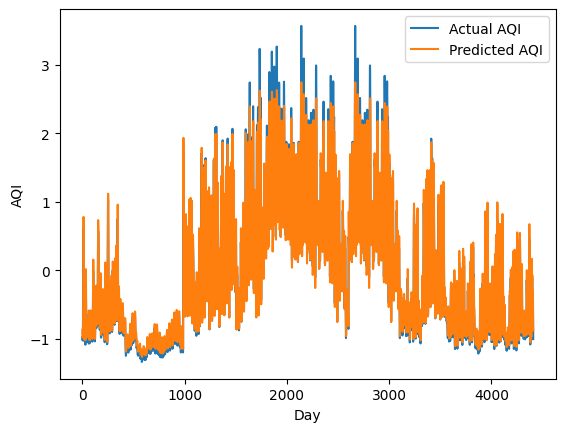

In [30]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual AQI')
plt.plot(predicted, label='Predicted AQI')
plt.xlabel('Day')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [31]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = target_scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 98.74549143,  89.34808516,  84.05795203, ..., 161.66209834,
       127.24036915,  97.22827503])

In [32]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = target_scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 82.48999696,  77.77999139,  76.00500263, ..., 122.07499951,
        93.36000383,  78.8149939 ])

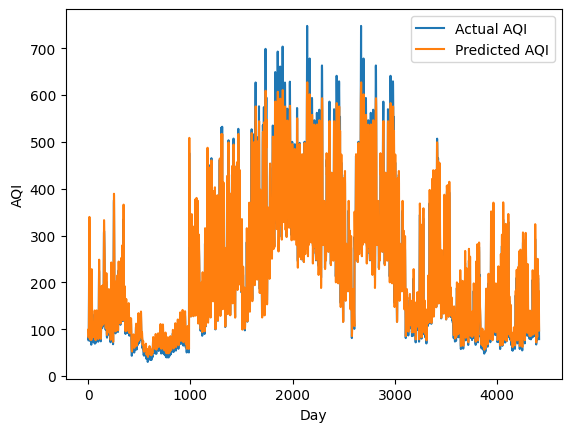

In [33]:
plt.plot(new_y_train, label='Actual AQI')
plt.plot(train_predictions, label='Predicted AQI')
plt.xlabel('Day')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [34]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = target_scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([ 82.29033518,  77.28773283,  75.08810794,  70.88377712,
        67.25690112,  71.76190813,  91.21513549, 122.05028963,
       147.1225562 , 154.97829821, 151.32986548, 145.89991058,
       139.9387238 , 131.96464687, 125.41464171, 122.56844597,
       122.17488718, 132.11990249, 148.26178741, 170.28305184,
       180.89712059, 168.19964812, 140.74331911, 117.82862958,
       100.80108452,  88.54307934,  84.71904835,  91.39618406,
       108.62230782, 123.21648422, 148.51255471, 181.88112239,
       203.3222003 , 206.31533642, 199.13528169, 192.03249666,
       183.60914579, 170.64549837, 156.3292448 , 140.83780886,
       124.18732314,  75.10285177,  74.98895398,  99.86892194,
       122.63481065, 127.16100754, 119.88233602, 111.70050043,
       105.70300437,  99.40146934,  95.34869944,  97.49953345,
       103.20064195, 103.20846806, 109.40790561, 122.39353774,
       131.2700363 , 126.6423446 , 114.55572764, 102.59942932,
        94.32720047,  88.6537279 ,  84.79157958,  82.08

In [35]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = target_scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([ 72.85499501,  69.13499184,  63.18500268,  59.52500548,
        66.53999139,  88.92999991, 117.95999636, 137.10999705,
       142.39999917, 141.17500397, 138.67499986, 133.74000249,
       126.08000046, 120.23000379, 117.60000422, 116.75500315,
       127.44500085, 141.58500108, 161.47000064, 168.85000101,
       157.41999958, 134.52499759, 114.82500333,  96.94499795,
        83.54999758,  80.15000003,  87.66999687, 104.85499863,
       115.90000108, 141.5349961 , 171.0199985 , 187.56500211,
       191.96500086, 189.87500042, 186.50000099, 179.11500012,
       166.87000059, 153.53999796, 137.90999801, 120.67000388,
        61.69000683,  77.51000821, 100.65500012, 116.60000083,
       116.66500293, 110.57000372, 104.73500417,  99.52500127,
        92.84999678,  89.22499869,  92.30000321,  97.58000433,
        95.58500242, 103.87499723, 116.68000005, 123.12499914,
       117.18500225, 106.65999912,  96.09999687,  88.40499573,
        82.4700037 ,  78.33499856,  75.36499138,  73.93

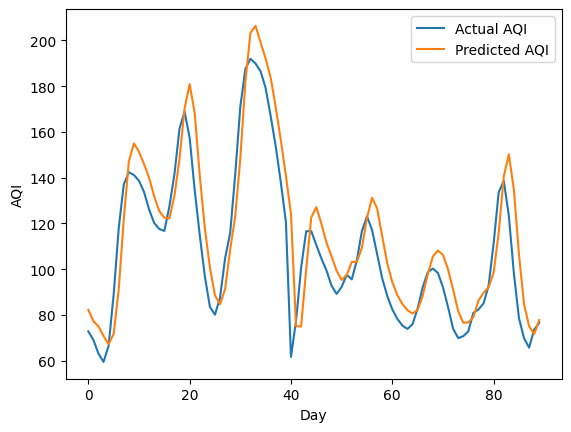

In [36]:
plt.plot(new_y_test, label='Actual AQI')
plt.plot(test_predictions, label='Predicted AQI')
plt.xlabel('Day')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [37]:
# Saving the model
model.eval()
torch.save(model, "new_1_lstm_model.pt")  
# def save_model(model, filename):
#   """Saves the model's state dictionary to a file.

#   Args:
#       model (nn.Module): The model to save.
#       filename (str): The filename to save the model state dictionary to.
#   """
#   model.eval()  # Set the model to evaluation mode (optional but recommended)
#   torch.save(model.state_dict(), filename)

# # Example usage:
# model = LSTM(1, 12, 1)
# model.to(device)
# save_model(model, "new_lstm_model.pt")

In [38]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_function,
            }, 'model.pt')


# model = LSTM(1, 4, 2)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# checkpoint = torch.load('model.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model = torch.load('new_1_lstm_model.pt')
for param in model.lstm.parameters():  # Freeze LSTM layer weights (example)
  param.requires_grad = False


# model.eval()
# # - or -
# model.train()

In [39]:
def model_data(df):
    df['date'] = pd.to_datetime(df['date'])
    shifted_df = prepare_data(df, lookback)
    shifted_df_as_np = shifted_df.to_numpy()
    # preparing the data for the model
    X = shifted_df_as_np[:, 1:]
    y = shifted_df_as_np[:, 0]
    # loading the scaler
    data_scaler = joblib.load('data_scaler.pkl')
    target_scaler = joblib.load('target_scaler.pkl')
    # scaling the data
    scaled_data = data_scaler.transform(X)
    # preparing the data for the model
    X = scaled_data
    y = target_scaler.transform(y.reshape(-1, 1))
    # flipping X
    X = dc(np.flip(X, axis=1))
    # reshaping X and y
    X_ = X.reshape((-1, lookback, 1))
    y_ = y.reshape((-1, 1))
    # converting to tensor
    X_ = torch.tensor(X_).float().to(device)
    y_ = torch.tensor(y_).float().to(device)
    # now using the dataset class
    dataset = TimeSeriesDataset(X_, y_)
    # creating a dataloader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader, X_, y_


df = pd.read_csv('lahore.csv')
data, x, y = model_data(df[['date', 'AQI']])


C:\Users\timmy\AppData\Local\Temp\ipykernel_17836\3377460253.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


In [40]:
x.shape

torch.Size([4500, 6, 1])

In [41]:
# finetune the model on thw whole data

def train_one_epoch():
  model.train(True)
  print(f'Epoch: {epoch +1 }')

  running_loss = 0.0

  for batch_index, batch in enumerate(data):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    output = model(x_batch)
    loss = loss_function(output, y_batch)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch_index % 100==99: # printing every 100 batch
      avg_loss_across_batches = running_loss/100
      print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                  avg_loss_across_batches))
      running_loss = 0.0
  print()
  
def validate_one_epoch():
  model.train(False)
  running_loss = 0.0

  for batch_index, batch in enumerate(data):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    with torch.no_grad():
      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

  avg_loss_across_batches = running_loss / len(data)

  print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
  print('***************************************************')
  print()

In [42]:
learning_rate = 0.0001
num_epochs = 5

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.029
Batch 200, Loss: 0.060

Val Loss: 0.040
***************************************************

Epoch: 2
Batch 100, Loss: 0.029
Batch 200, Loss: 0.059

Val Loss: 0.040
***************************************************

Epoch: 3
Batch 100, Loss: 0.029
Batch 200, Loss: 0.058

Val Loss: 0.039
***************************************************

Epoch: 4
Batch 100, Loss: 0.029
Batch 200, Loss: 0.057

Val Loss: 0.039
***************************************************

Epoch: 5
Batch 100, Loss: 0.029
Batch 200, Loss: 0.056

Val Loss: 0.039
***************************************************



In [43]:
# Saving the model
model.eval()
torch.save(model, "best_model.pt")  

## Testing section

In [44]:
def prepare_data(df, n_steps):
  df = dc(df)
  df['date'] = pd.to_datetime(df['date'])

  df.set_index('date', inplace=True)

  for i in range(1, n_steps+1):
    df[f"AQI(t-{i})"] = df['AQI'].shift(i)

  df.dropna(inplace=True)

  return df

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
batch_size = 16

In [45]:
def model_data(df):
    df['date'] = pd.to_datetime(df['date'])
    shifted_df = prepare_data(df, lookback)
    shifted_df_as_np = shifted_df.to_numpy()

    # preparing the data for the model
    X = shifted_df_as_np[:, 1:]
    y = shifted_df_as_np[:, 0]
    # flipping X
    X = dc(np.flip(X, axis=1))
    # loading the scaler
    data_scaler = joblib.load('data_scaler.pkl')
    target_scaler = joblib.load('target_scaler.pkl')
    # scaling the data
    scaled_data = data_scaler.transform(X)
    scald_target = target_scaler.transform(y.reshape(-1, 1))
    
    # reshaping X and y
    X_ = scaled_data.reshape((-1, lookback, 1))
    y_ = scald_target.reshape((-1, 1))
    # converting to tensor
    X_ = torch.tensor(X_).float().to(device)
    y_ = torch.tensor(y_).float().to(device)
    # now using the dataset class
    dataset = TimeSeriesDataset(X_, y_)
    # creating a dataloader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader, X_, y_

# model loading function
def load_model():
    model = torch.load('best_model.pt')
    for param in model.lstm.parameters():
        param.requires_grad = False
    return model


def predict(dataloader):
    model = load_model()
    model.eval()
    predictions = []
    y_ = []
    with torch.no_grad():
        for X, y in dataloader:
            y_pred = model(X)
            predictions.append(y_pred)
            y_.append(y)
    return predictions, y_

In [46]:
import pandas as pd
def create_hourly_increments(date):
    # getting the next date
    date = pd.to_datetime(date)
    next_date = date + pd.DateOffset(days=4)
    return pd.date_range(start=date, end=next_date,  freq='H')
    
def get_date_data(date):
    df = pd.read_csv('lahore.csv')
    df['date'] = pd.to_datetime(df['date'])
    # convert date to datetime
    date_dt = pd.to_datetime(date)
    # getting the hourly increments for the selected date
    hourly_df = pd.DataFrame({'date': create_hourly_increments(date)})
    data_ = df[df['date'].isin(hourly_df['date'].astype(str).values.tolist())]
    return data_

d = get_date_data('2024-04-17')


In [47]:
d

,date,AQI,latitude,longitude
4433,2024-04-17 00:00:00,141.585,31.742221,74.474629
4434,2024-04-17 01:00:00,161.470,31.742221,74.474629
4435,2024-04-17 02:00:00,168.850,31.742221,74.474629
4436,2024-04-17 03:00:00,157.420,31.742221,74.474629
4437,2024-04-17 04:00:00,134.525,31.742221,74.474629
...,...,...,...,...
4501,2024-04-19 20:00:00,78.665,31.742221,74.474629
4502,2024-04-19 21:00:00,69.900,31.742221,74.474629
4503,2024-04-19 22:00:00,65.780,31.742221,74.474629
4504,2024-04-19 23:00:00,73.635,31.742221,74.474629


In [48]:
len(d)

73

In [49]:
loader, x, y = model_data(d[['date', 'AQI']])

C:\Users\timmy\AppData\Local\Temp\ipykernel_17836\3198408548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


In [50]:
model = load_model()
model.eval()
model

LSTM(
  (lstm): LSTM(1, 12, batch_first=True)
  (fc): Linear(in_features=12, out_features=1, bias=True)
)

In [51]:
predictions, y = predict(loader)

In [52]:
# a function for making plot
def make_plot(predictions, y):
    scaler = joblib.load('target_scaler.pkl')   
    predictions = torch.cat(predictions).cpu().numpy().flatten()
    y = torch.cat(y).cpu().numpy().flatten()

    dummies = np.zeros((len(predictions), lookback+1))
    dummies[:, 0] = predictions
    dummies = scaler.inverse_transform(dummies)

    predictions = dc(dummies[:, 0])

    dummies = np.zeros((len(y), lookback+1))
    dummies[:, 0] = y.flatten()
    dummies = scaler.inverse_transform(dummies)

    new_y = dc(dummies[:, 0])

    plt.plot(new_y, label='Actual AQI')
    plt.plot(predictions, label='Predicted AQI')
    plt.xlabel('Hour')
    plt.ylabel('AQI')
    plt.legend()
    plt.show()

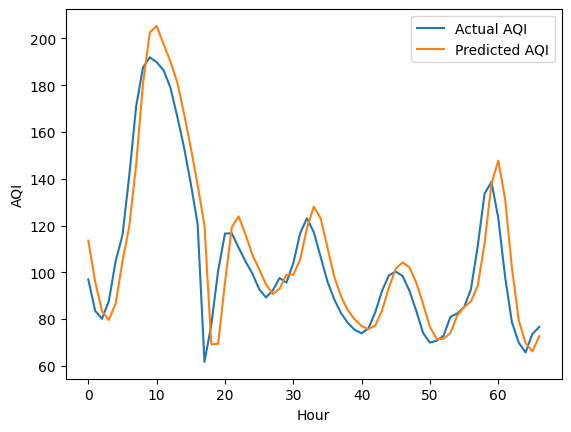

In [53]:
make_plot(predictions, y)

In [54]:
data_scaler = joblib.load('data_scaler.pkl')
data_scaler

StandardScaler()

In [57]:
def predict_today(n=24):
    # loading the database
    data = pd.read_csv('clean.csv')
    # getting today's date
    today_date = date.today()
    today_date = pd.to_datetime(today_date)
    # get last date in the data
    last_date = data['date'].iloc[-1]
    # converting both to time and getting the total hours between them
    last_date = pd.to_datetime(last_date)
    hours_diff = (today_date - last_date).total_seconds() / 3600
    aqi_data = data['AQI'].values.tolist()
    model = load_model()
    data_scaler = joblib.load('data_scaler.pkl')
    target_scaler = joblib.load('target_scaler.pkl')
    lookback = 6
    # ensureing we are just collecting the last 6 values
    current_data = aqi_data[-lookback:]
    predictions = []
    model.eval()
    for _ in range(int(hours_diff)):
        # Ensure current_data has the required length
        if len(current_data) != lookback:
            raise ValueError(f"Current data must have length {lookback}")

        # Prepare data for the model (scaling and reshaping)
        current_data_np = np.array([current_data])  # Assuming data is a list
        scaled_data = data_scaler.transform(current_data_np)
        X = scaled_data.reshape((1, lookback, 1))
        X_ = torch.tensor(X).float().to(device)

        # Make prediction
        with torch.no_grad():
            y_pred = model(X_)

        # Inverse scaling of the predicted value (assuming single value prediction)
        predicted_value = target_scaler.inverse_transform(y_pred.cpu().detach().numpy())[0][0]

        # Update current_data for the next iteration
        current_data.append(predicted_value)
        current_data = current_data[-lookback:]  # Keep only the last lookback values

        # Append the prediction to the final list
        predictions.append(predicted_value)

    return predictions[-24:]


In [58]:
pred = predict_today()
pred

[342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928]

In [61]:
# predicting for thr last seven days
def predict_last_seven_days():
    # getting the data
    data = pd.read_csv('clean.csv')
    # converting date to the right format
    data['date'] = pd.to_datetime(data['date'])
    # today's date
    today_date = date.today()
    # last seven days
    last_seven_days = today_date - timedelta(days=7)
    # converting to datetime
    today_date = pd.to_datetime(today_date)
    last_seven_days = pd.to_datetime(last_seven_days)
    # caalculating the hours difference
    hours_diff = (today_date - last_seven_days).days * 24
    # the prev day before the last seven days data
    previous_day_hrs = hours_diff + 24 
    # getting the data
    aqi_data = data['AQI'].values.tolist()[-previous_day_hrs:-hours_diff]
    # loading model
    model = load_model()
    # loading scalers
    data_scaler = joblib.load('data_scaler.pkl')
    target_scaler = joblib.load('target_scaler.pkl')
    # lookback
    lookback = 6
    # current data
    current_data = aqi_data[-lookback:]
    # predictions
    predictions = []
    # loop to make predictions
    for _ in range(hours_diff):
        if len(current_data) != lookback:
            raise ValueError(f"Current data must have length {lookback}")

        current_data_np = np.array([current_data])
        scaled_data = data_scaler.transform(current_data_np)
        X = scaled_data.reshape((1, lookback, 1))
        X_ = torch.tensor(X).float().to(device)

        with torch.no_grad():
            y_pred = model(X_)

        predicted_value = target_scaler.inverse_transform(y_pred.cpu().detach().numpy())[0][0]

        current_data.append(predicted_value)
        current_data = current_data[-lookback:]

        predictions.append(predicted_value)

    return predictions[-24*7:]

In [62]:
predict_last_seven_days()

[62.309452,
 63.52802,
 65.197716,
 67.00915,
 68.89056,
 70.812904,
 72.766914,
 74.752205,
 76.767845,
 78.81686,
 80.902626,
 83.02915,
 85.20074,
 87.42193,
 89.69752,
 92.032616,
 94.43249,
 96.90275,
 99.44929,
 102.0783,
 104.79632,
 107.610275,
 110.52747,
 113.5556,
 116.70281,
 119.97769,
 123.38924,
 126.94692,
 130.6607,
 134.54095,
 138.59848,
 142.84451,
 147.29062,
 151.9487,
 156.8308,
 161.94908,
 167.31577,
 172.94267,
 178.84125,
 185.02202,
 191.49425,
 198.26526,
 205.33961,
 212.71808,
 220.39613,
 228.36238,
 236.59631,
 245.06606,
 253.72595,
 262.51443,
 271.35275,
 280.145,
 288.78018,
 297.13675,
 305.0892,
 312.5165,
 319.311,
 325.3864,
 330.68396,
 335.17538,
 338.8632,
 341.7781,
 343.97467,
 345.52563,
 346.51584,
 347.03632,
 347.1791,
 347.03262,
 346.67825,
 346.1879,
 345.6226,
 345.03192,
 344.45413,
 343.91702,
 343.439,
 343.03052,
 342.69562,
 342.43326,
 342.23877,
 342.1051,
 342.0237,
 341.9855,
 341.98145,
 342.003,
 342.04248,
 342.09323,
 3

In [65]:
# next seven days prediction
def predict_next_seven_days():
    # loading the database
    data = pd.read_csv('clean.csv')
    # getting today's date
    today_date = date.today()
    today_date = pd.to_datetime(today_date)
    # get last date in the data
    last_date = data['date'].iloc[-1]
    # converting both to time and getting the total hours between them
    last_date = pd.to_datetime(last_date)
    hours_diff = (today_date - last_date).total_seconds() / 3600
    # adding 168 to the hours diff
    hours_diff += 168
    aqi_data = data['AQI'].values.tolist()
    model = load_model()
    model.eval
    data_scaler = joblib.load('data_scaler.pkl')
    target_scaler = joblib.load('target_scaler.pkl')
    lookback = 6
    # ensureing we are just collecting the last 6 values
    current_data = aqi_data[-lookback:]
    predictions = []
    for _ in range(int(hours_diff)):
        # Ensure current_data has the required length
        if len(current_data) != lookback:
            raise ValueError(f"Current data must have length {lookback}")

        # Prepare data for the model (scaling and reshaping)
        current_data_np = np.array([current_data])  # Assuming data is a list
        scaled_data = data_scaler.transform(current_data_np)
        X = scaled_data.reshape((1, lookback, 1))
        X_ = torch.tensor(X).float().to(device)

        # Make prediction
        with torch.no_grad():
            y_pred = model(X_)

        # Inverse scaling of the predicted value (assuming single value prediction)
        predicted_value = target_scaler.inverse_transform(y_pred.cpu().detach().numpy())[0][0]

        # Update current_data for the next iteration
        current_data.append(predicted_value)
        current_data = current_data[-lookback:]  # Keep only the last lookback values

        # Append the prediction to the final list
        predictions.append(predicted_value)

    return predictions[-168:]

In [66]:
predict_next_seven_days()

[342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342.44928,
 342